# Defining single-chain Structure Factor

### How to evaluate:
1) Fourier transform of pair correlation function (466 Lec 4)

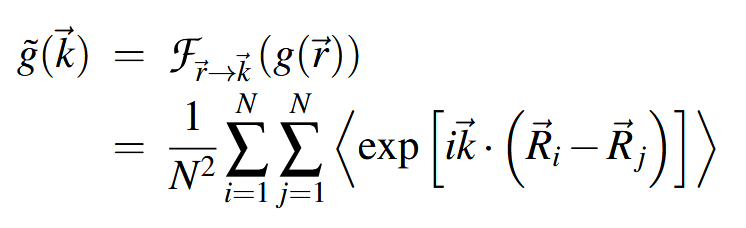


    a) Laplace inversion of wlc Green's function in Fourier-Laplace space (wlcstat doc)
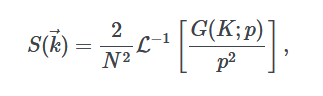
    


2) I_s(q) / I_s(q=0) (466 Lec 7, Rubinstein 2.8.2)
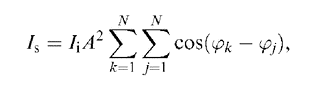
 
### Why it matters:

 "correlating scattering experiments with theoretical models provides insight into the physical behavior in polymeric fluids"
 
 generally, can tell error in [R_ij] -> at small scattering wavevector q, can compare <R_g^2>
 
 Experimentally verify theory polymer behavior in presence of different solvents

Fundamentally, any structure facot is essentially letting you know about how densities correlate
AB structure factor- at some position with vol frac A, what is the probability of vol frac B a certain distance away

#### meaning of single-chain?
Experimental result is a summation of monomer on a chain- makes sense

Analytical result (at small q) averaging over ensemble? single chain != in isolation?

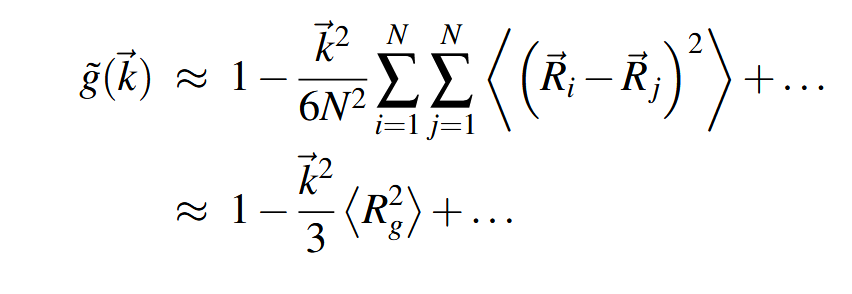



#### How does solvent enviroment impact these results?

structure factor essentially only depends on chain conformation and scattering wavevector


but, for the analytical solution, introducing interactions (bead-bead, bead-solvent) would change polymer conformations


Are these interactions considered in the evaluation of structure factor? (quasi-chemical solution model

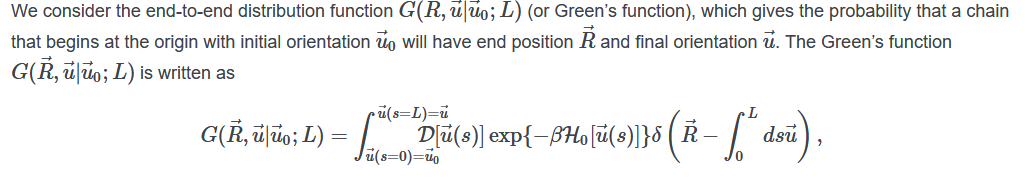

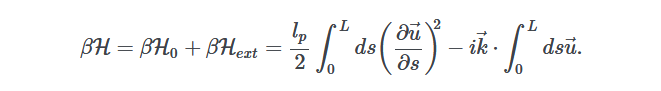

In [266]:
import numpy as np
np.seterr(divide='ignore', invalid='ignore')
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import pandas as pd
import wlcave as wlcave #need to path correctly!
import matplotlib.cm as cm
import sys
from wlcstat.wlcstruc import *
import itertools

#for data processing
import os
import operator
import xlrd

In [336]:
import matlab.engine
eng = matlab.engine.start_matlab()

Two appraoches: 

- Fourier transform of pair correlation function
- Ratio of I_scattered(q) / I_scattered(q=0)

### Simulation Solution:

#### ABmelt:

In [268]:
#EDIT PATHS
# chi_zero_1_path = "C:\\users/tmhab/wlcsim_membrane/data/AB_melt_phase_diagram/5.13.21_ABmelt_fully_reproduced_shorter_range_96hrs_OLD/all_rs/r50v1"
# chi_zero_2_path = "C:\\users/tmhab/wlcsim_membrane/data/AB_melt_phase_diagram/5.8.21_ABmelt_fully_reproduced_72hrs_OLD/all_rs/r39v1"
# chi_zero_3_path = "C:\\users/tmhab/wlcsim_membrane/data/AB_melt_phase_diagram/5.8.21_ABmelt_fully_reproduced_160hrs_OLD/all_rs/r92v1"
# chi_zero_4_path = "C:\\users/tmhab/wlcsim_membrane/data/AB_melt_phase_diagram/5.8.21_ABmelt_fully_reproduced_96hrs_OLD/all_rs/r49v1"
# chi_zero_5_path = "C:\\users/tmhab/wlcsim_membrane/data/AB_melt_phase_diagram/5.8.21_ABmelt_fully_reproduced_120hrs_OLD/all_rs/r64v1"

chi_zero_1_path = "C:\\users/Thomas/wlcsim_membrane/data/struc_fac/r50v1"
chi_zero_2_path = "C:\\users/Thomas/wlcsim_membrane/data/struc_fac/r39v1"
chi_zero_3_path = "C:\\users/Thomas/wlcsim_membrane/data/struc_fac/r92v1"
chi_zero_4_path = "C:\\users/Thomas/wlcsim_membrane/data/struc_fac/r49v1"
chi_zero_5_path = "C:\\users/Thomas/wlcsim_membrane/data/struc_fac/r64v1"

name_list = ["X", "Y", "Z", "Type"] 
chi_zero_1_df = pd.read_csv(chi_zero_1_path, names = name_list, delim_whitespace=True)
chi_zero_2_df = pd.read_csv(chi_zero_2_path, names = name_list, delim_whitespace=True)
chi_zero_3_df = pd.read_csv(chi_zero_3_path, names = name_list, delim_whitespace=True)
chi_zero_4_df = pd.read_csv(chi_zero_4_path, names = name_list, delim_whitespace=True)
chi_zero_5_df = pd.read_csv(chi_zero_5_path, names = name_list, delim_whitespace=True)
chi_zero_list = [chi_zero_1_df, chi_zero_2_df, chi_zero_3_df, chi_zero_4_df, chi_zero_5_df]

macroletters

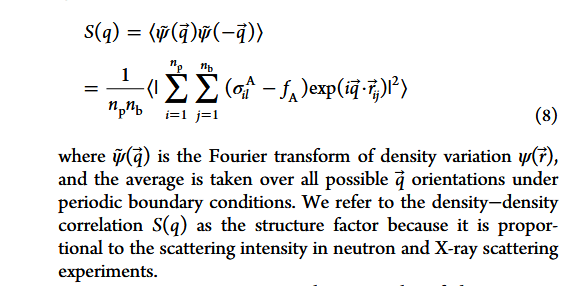

soft matter

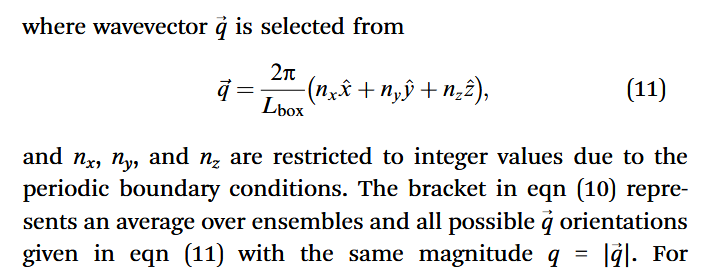

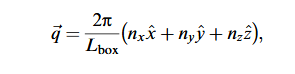

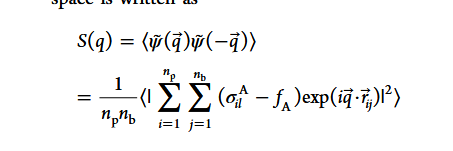

In [269]:
def gen_triples_vector(rnge):
    #to make sute itertools.combinations creates all permutations
    lst = []
    for i in range(rnge):
        lst += ([i]*3)
    return lst

In [270]:
def get_mag_vec_map(rnge, l_box = 20):
    comb_dict = {}
    #gen apropraiate vector
    trips = gen_triples_vector(rnge)
    for comb in itertools.combinations(trips, 3):
        comb = np.array(comb)
        comb_mag = np.linalg.norm(comb* (2*np.pi/l_box))
        # if comb_mag not in dictionary
        if comb_mag not in comb_dict:
            comb = comb * (2*np.pi/l_box)
            permutes = list(itertools.permutations(comb))
            for i in range(len(permutes)):
                #permutes[i] = list(permutes[i])
                permutes[i] = np.array(list(permutes[i]))
            permutes = np.unique(np.array(permutes), axis=0)
            comb_dict[comb_mag] = permutes
    return comb_dict

In [366]:
#TO DO
#gaussian smoothing didnt work, so try averaging over ensembles DONE
#also, R_m could be wrong- may need to calculate? DONE
def structure_factor_from_sim(df, q_vectors, n_p, n_b, f_A, l_box=20):
    '''
    melt structure factor.  
    q_vectors is a list of vectors with same magnitude
    '''
#     q_vectors= np.array([])    
#     q_mag_squared = ((q*l_box)/(2*np.pi))**2
    
#     if int(q_mag_squared) != q_mag_squared:
#         return None
#     else:
#         q_vectors = find_q_vects((q*l_box)/(2*np.pi))
 
    sum_avg = 0
    #print(np.shape(q_vectors)[0])
    for q_vect in q_vectors:
        #q_vect = q_vect * (2*np.pi)/l_box   MULTIPLYING THIS TWICE?????
        summ = 0
        #(A*e^B)
        A = df.Type - f_A
        B = 1j*np.dot(df.iloc[:,:3], q_vect)
        summ = (A*np.exp(B)).sum()            
        sum_avg += (np.absolute(summ)**2)/(np.shape(q_vectors)[0])#q_vectors.size
    return sum_avg * (1/(n_p*n_b))
    

In [272]:
#constants
f_A = 0.5
n_p = 2000
n_b = 40
l_box = 20
# inputs
#q=(2*np.pi*3)/l_box

#chi_zero_df
#R_m = 1#2.03 #unperturbed average end-to-end separation of a monomer

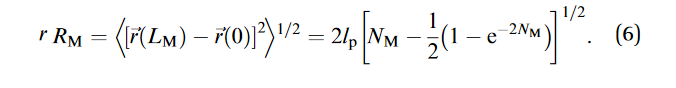

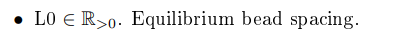

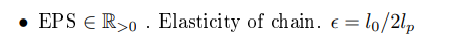

In [275]:
EPS = 0.01
L0 = 0.406666
l_pers = L0/(EPS*2)  #= 20.3
l_kuhn = 2*l_pers
N_M = 5*L0/(l_kuhn) #= 0.05

In [276]:
40*L0/l_kuhn #num kuhn lengths per polymer

0.4

In [277]:
R_M = 2*l_pers*(N_M - 0.5*(1-np.exp(-2*N_M)))**0.5

### Structure factor from simulation

In [367]:
mag_vects_map = get_mag_vec_map(20, l_box = 20)
sorted_magnitudes = sorted(mag_vects_map.keys())
structure_fact_array = np.array([])
for mag in sorted_magnitudes:
    q_vectors = mag_vects_map[mag]
#     for i,vec in enumerate(q_vectors): #put q vectors in terms of R_M
#         q_vectors[i] = vec*R_M
    #print(q_vectors)
    sf_average = 0
    for df in chi_zero_list: #avging over ensembles
        sf = structure_factor_from_sim(df, q_vectors, n_p, n_b, f_A, l_box=20)
        sf_average += sf/(len(chi_zero_list))
    structure_fact_array = np.append(structure_fact_array, sf_average)


In [365]:
mag_vects_map

{0.0: array([[0., 0., 0.]]),
 0.3141592653589793: array([[0.        , 0.        , 0.31415927],
        [0.        , 0.31415927, 0.        ],
        [0.31415927, 0.        , 0.        ]]),
 0.6283185307179586: array([[0.        , 0.        , 0.62831853],
        [0.        , 0.62831853, 0.        ],
        [0.62831853, 0.        , 0.        ]]),
 0.9424777960769379: array([[0.       , 0.       , 0.9424778],
        [0.       , 0.9424778, 0.       ],
        [0.9424778, 0.       , 0.       ]]),
 1.2566370614359172: array([[0.        , 0.        , 1.25663706],
        [0.        , 1.25663706, 0.        ],
        [1.25663706, 0.        , 0.        ]]),
 1.5707963267948966: array([[0.        , 0.        , 1.57079633],
        [0.        , 1.57079633, 0.        ],
        [1.57079633, 0.        , 0.        ]]),
 1.8849555921538759: array([[0.        , 0.        , 1.88495559],
        [0.        , 1.88495559, 0.        ],
        [1.88495559, 0.        , 0.        ]]),
 2.199114857512855: 

In [179]:
# sort_magss = np.array(sorted_magnitudes)
# plt.loglog(sort_magss*R_M, structure_fact_array)
# plt.title("rigid melt structure factor chi=0")
# plt.xlabel("R_m*q")
# plt.ylabel("<>")
# plt.ylim((10**-1, 10**3))
# print("NEW ONE!")

In [40]:
(40*L0)/l_kuhn #num kuhn lengths per polymer

0.4

In [102]:
N_M * 8

0.4

### Structure factor from wlcstat (INCORRECT)

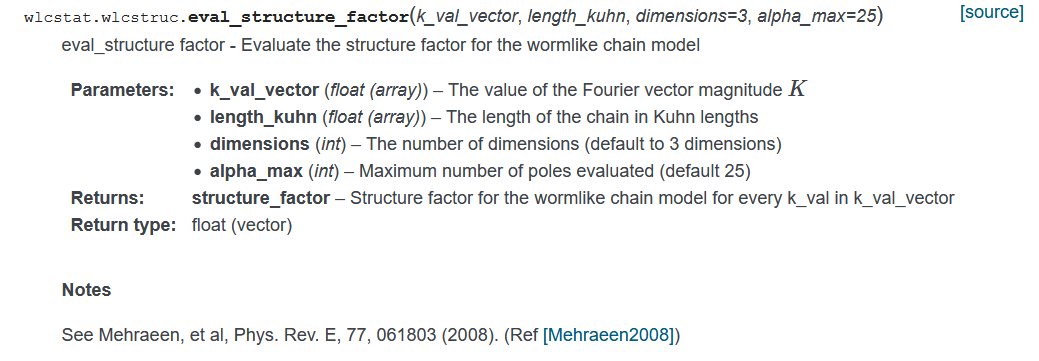

Scattering vector = scattering wave vector = q = k

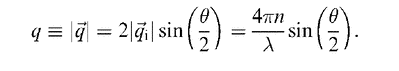

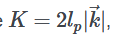

In [217]:
# wlcstat old
#wlc- l_k = 2 * l_p
#l_kuhn = 4.06
k_val = sort_magss * 2*l_pers
structure_factor = eval_structure_factor(k_val, (n_b*L0)/l_kuhn)#, dimensions=3)

### Structure factor from 2016 Macromolecules- ABmelt

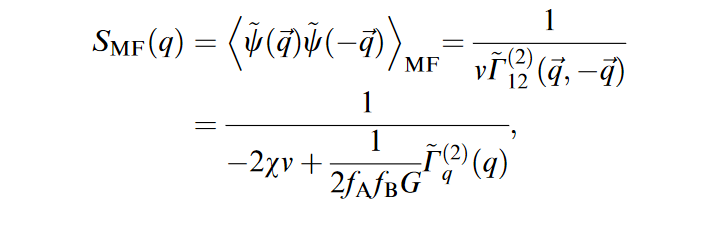

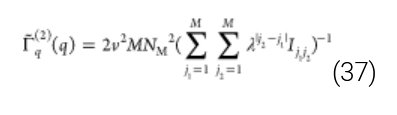

In [95]:
# # # calc from 2016 Macromolecules abmelt. lambda = 0
# Q0=10e0#; %minimumwavevector
# QF=20#; %maximumwavevector
# NQ=100#; %numberofwavevectors

# Q=np.transpose(np.logspace(np.log10(Q0),np.log10(QF),NQ))/R_M#RM;
# Q_matlab_org = matlab.double(Q.tolist())
# Q_matlab = matlab.double(np.array(sorted_magnitudes).tolist())

In [401]:

R_M_kuhn = np.sqrt(eng.r2wlc(N_M)) #end-to-end monomer seperation in kuhn lengths
mags_kuhn = (np.array(sorted_magnitudes)/R_M_kuhn)*R_M #how Q should be for this function
Q_matlab = matlab.double(mags_kuhn.tolist()) #function needs it in terms of R_M_kuhn

num_monomers = 8#*2000
lambda_val = 0
sinv = eng.s2invwlc(matlab.double([num_monomers]), matlab.double([N_M]), matlab.double([f_A]), matlab.double([lambda_val]), Q_matlab)
sinv_arr = np.array([])
for elem in sinv:
    sinv_arr= np.append(sinv_arr, float(np.array(elem)))


# TEST 2016 FUNC

In [387]:
N_M_testing = 0.1
R_M_kuhn_testing = np.sqrt(eng.r2wlc(matlab.double([N_M_testing]))) #end-to-end monomer seperation in kuhn lengths
Q_matlab = matlab.double((np.array(sorted_magnitudes)/R_M_kuhn_testing).tolist()) #function needs it in terms of R_M_kuhn

num_monomers = 100 #no impact
lambda_val = -.75
sinv_test = eng.s2invwlc(matlab.double([num_monomers]), matlab.double([N_M_testing]), matlab.double([f_A]), matlab.double([lambda_val]), Q_matlab)
sinv_arr_test = np.array([])
for elem in sinv_test:
    sinv_arr_test = np.append(sinv_arr_test, float(np.array(elem)))


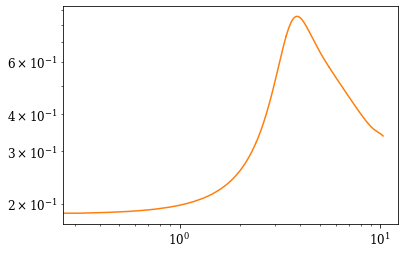

In [392]:
plt.loglog((np.array(sorted_magnitudes)/R_M_kuhn_testing)*R_M_kuhn_testing, (1/sinv_arr_test), label = "2016 macromolecules", color = "tab:orange")

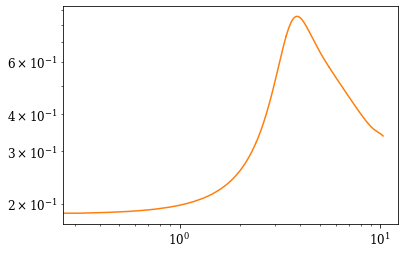

In [390]:
plt.loglog(sort_magss, (1/sinv_arr_test), label = "2016 macromolecules", color = "tab:orange")

In [385]:
#np.array(sorted_magnitudes)/R_M_kuhn_testing

In [386]:
# calc from 2016 Macromolecules abmelt. lambda = 0
Q0=1#; %minimumwavevector
QF=10#; %maximumwavevector
NQ=100#; %numberofwavevectors
Q=np.transpose(np.logspace(np.log10(Q0),np.log10(QF),NQ))/R_M_kuhn_testing#RM;
Q_matlab_2 = matlab.double(Q.tolist())
sinv_test_2 = eng.s2invwlc(matlab.double([num_monomers]), matlab.double([N_M_testing]), matlab.double([f_A]), matlab.double([lambda_val]), Q_matlab_2)
sinv_arr_test_2 = np.array([])
for elem in sinv_test_2:
    sinv_arr_test_2 = np.append(sinv_arr_test_2, float(np.array(elem)))


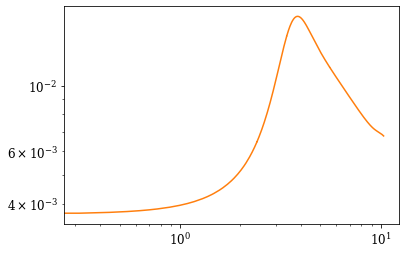

In [362]:
plt.loglog((sort_magss/R_M_kuhn_testing)*(R_M_kuhn_testing), (1/sinv_arr_test), label = "2016 macromolecules", color = "tab:orange")

# END OF TEST
conc: could multiply struc fact by 100 or mulpilt N_M by 100

In [215]:
print(N_M)
print(R_M)
print(R_M_kuhn*2*l_pers)

0.05
1.9999985275191092
1.9999985275191092


In [332]:
l_pers*2*0.05

2.0333300000000003

In [110]:
# # EXAMPLE- works
# Q0=1e-2#; %minimumwavevector
# QF=1e4#; %maximumwavevector
# NQ=201#; %numberofwavevector
# R_M_2016 = np.sqrt(eng.r2wlc(0.1))
# Q=np.transpose(np.logspace(np.log10(Q0),np.log10(QF),NQ))#/R_M
# Q_matlab = matlab.double(Q.tolist())
# num_monomers = 100
# lambda_val = -0.75
# N_M_2016 = 0.1
# sinv = eng.s2invwlc(matlab.double([num_monomers]), matlab.double([N_M_2016]), matlab.double([f_A]), matlab.double([lambda_val]), Q_matlab)
# sinv_arr = np.array([])
# for elem in sinv:
#     sinv_arr= np.append(sinv_arr, float(np.array(elem)))


In [218]:
# plt.loglog(sort_magss*R_M_kuhn*2*l_pers, 1/sinv_arr, label = "2016 calc matlab") #*2*l_pers

NEW ONE!


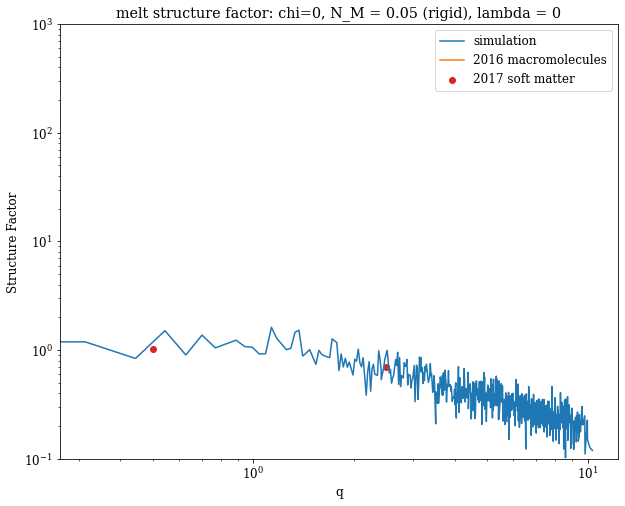

In [393]:
plt.figure(figsize=(10,8))
font = {'family' : 'serif',
    'weight':'normal',
    'size': 12}
plt.rc('font', **font)
sort_magss = np.array(sorted_magnitudes)
plt.loglog(sort_magss, structure_fact_array, label = "simulation") #*R_M
plt.title("melt structure factor: chi=0, N_M = 0.05 (rigid), lambda = 0")
plt.xlabel("R_m*q")
plt.ylabel("<>")
plt.ylim((10**-1, 10**3))
print("NEW ONE!")

#changed from * lungth_kuhn to * R_m
#plt.loglog(sort_magss, np.real(structure_factor), label = "OLD mft wlcstat", color = "tab:green")#not considering A or B interac

#2016
#plt.loglog(mags_kuhn*R_M_kuhn, (1/sinv_arr), label = "2016 macromolecules", color = "tab:orange") #*(2*l_pers) *R_M, *100

#plt.loglog(sort_magss, (1/sinv_arr)*100, alpha = 0.5, label = "2016 * 100", color = "tab:orange") #*(2*l_pers) *R_M, *100

plt.scatter([1/R_M, 5/R_M, 10/R_M], [1.02, 0.7, 0.38], label = "2017 soft matter", color = "tab:red")

#plt.loglog(sort_magss, (1/sinv_arr_test), label = "N_M * 100", color = "tab:green")

plt.xlabel(r'q') #R_m*
plt.ylabel(r'Structure Factor')
# plt.ylim((2, 3.5))
# plt.xlim((2, 20))
# plt.tight_layout()
plt.legend()

NEW ONE!


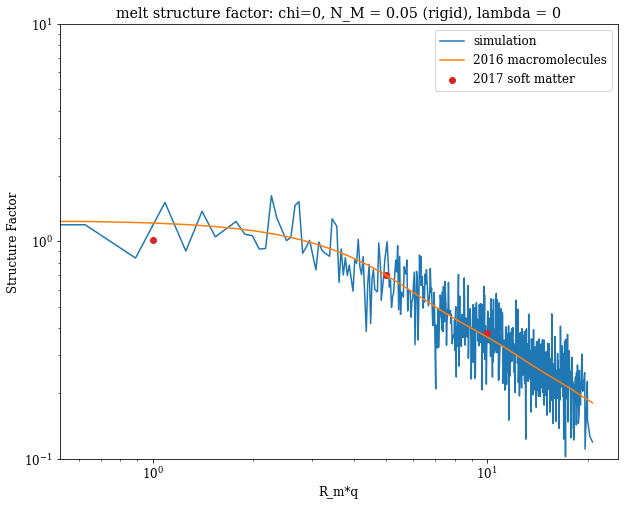

In [403]:
plt.figure(figsize=(10,8))
font = {'family' : 'serif',
    'weight':'normal',
    'size': 12}
plt.rc('font', **font)
sort_magss = np.array(sorted_magnitudes)
plt.loglog(sort_magss*R_M, structure_fact_array, label = "simulation", zorder=1) #*R_M
plt.title("melt structure factor: chi=0, N_M = 0.05 (rigid), lambda = 0")
plt.xlabel("R_m*q")
plt.ylabel("<>")
plt.ylim((10**-1, 10**1))
print("NEW ONE!")

#changed from * lungth_kuhn to * R_m
#plt.loglog(sort_magss * R_M, np.real(structure_factor)/(2*l_pers), label = "OLD mft wlcstat")#not considering A or B interac

#2016
plt.loglog(mags_kuhn*R_M_kuhn, (1/sinv_arr), label = "2016 macromolecules", color = "tab:orange") #*R_M
#mags_kuhn is in units q/R_M_kuhn. but, based on paper, they call this produce (R_M*q)
#plt.loglog(sort_magss*R_M, (1/sinv_arr)*100, alpha = 0.5, label = "2016 * 100", color = "tab:orange") #*(2*l_pers) *R_M, *100

#plt.loglog(sort_magss*R_M, (1/sinv_arr_test), label = "N_M * 100", color = "tab:green")

plt.scatter([1, 5, 10], [1.02, 0.7, 0.381], label = "2017 soft matter", color = "tab:red", zorder=2)
plt.xlabel(r'R_m*q') #R_m*
plt.ylabel(r'Structure Factor')
# plt.ylim((2, 3.5))
# plt.xlim((2, 20))
# plt.tight_layout()
plt.legend()

NEW ONE!


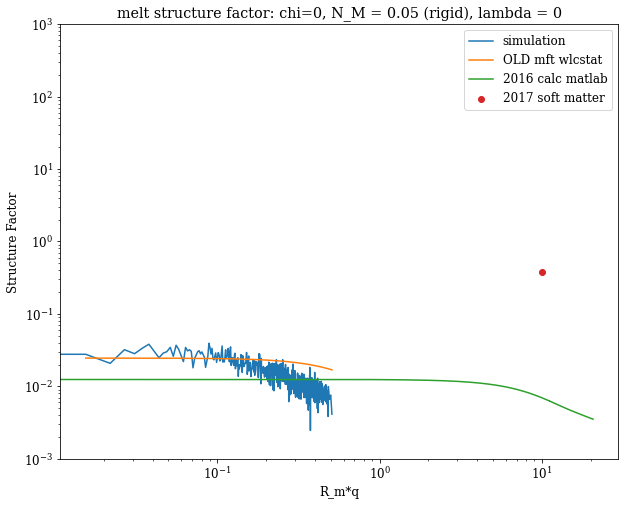

In [193]:
# Theoretical values!!
# num_k = 100
# k_val_0 = 1e-2
# k_val_f = 20
# length_kuhn_vec = np.array([0.1, 0.5, 1])
dimensions = 3

plt.figure(figsize=(10,8))
font = {'family' : 'serif',
    'weight':'normal',
    'size': 12}
plt.rc('font', **font)
sort_magss = np.array(sorted_magnitudes)
plt.loglog(sort_magss*R_M_kuhn, structure_fact_array/(2*l_pers), label = "simulation")
plt.title("melt structure factor: chi=0, N_M = 0.05 (rigid), lambda = 0")
plt.xlabel("R_m*q")
plt.ylabel("<>")
plt.ylim((10**-3, 10**3))
print("NEW ONE!")

#changed from * lungth_kuhn to * R_m
plt.loglog(sort_magss * R_M_kuhn, np.real(structure_factor)/(2*l_pers), label = "OLD mft wlcstat")#not considering A or B interac

#2016
plt.loglog(sort_magss*R_M_kuhn, (1/sinv_arr), label = "2016 calc matlab")

plt.scatter(10, 0.38, label = "2017 soft matter", color = "tab:red")
plt.xlabel(r'R_m*q')
plt.ylabel(r'Structure Factor')
# plt.ylim((2, 3.5))
# plt.xlim((2, 20))
# plt.tight_layout()
plt.legend()

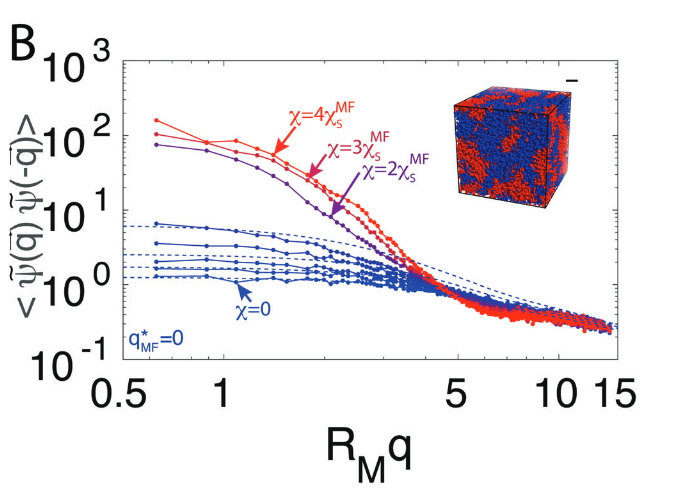

In [636]:
# y_vals = structure_fact_array
# x_vals = sort_magss*R_m
# sigma = 0.45 #paper- std dv = 0.45

# smoothed_vals = np.zeros(len(y_vals)+1)
# for i, x_val in enumerate(x_vals):
#     kernel = np.exp(-(x_vals - x_val) ** 2 / (2 * sigma ** 2)) #gaussian centerd at each point
#     kernel = kernel / sum(kernel) #normalize
#     smoothed_vals[i] = sum(y_vals * kernel)
    

In [638]:
# plt.loglog(x_vals, smoothed_vals[1:], color= "tab:orange")
# plt.ylim((10**-1, 10**3))

In [ ]:
#reproduce 2017 soft matter structuer factor plot
# edit fucntion for ab solution
# use on new data!!

#### EDITED ABsolution, 1000 poly:

define local volume fraction deviation = phi_A - f_A * phi_poly

# A-A structure factor

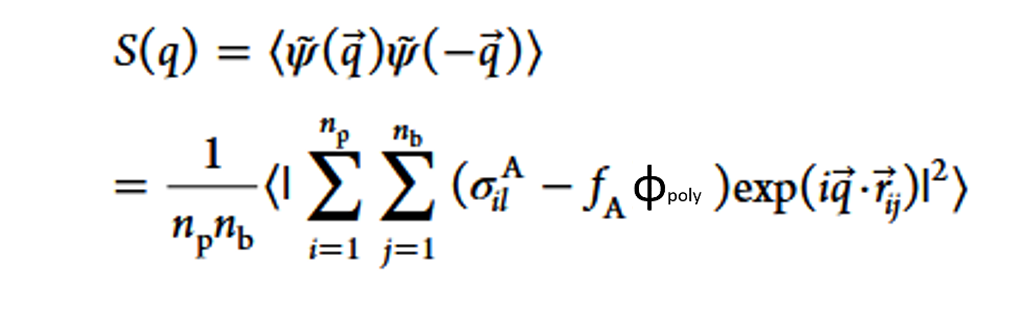

In [ ]:
chi_zero_1000_poly_list

In [221]:
#EDIT PATHS
# chi_zero_1_path = "C:\\users/tmhab/wlcsim_membrane/data/AB_melt_phase_diagram/5.13.21_ABmelt_fully_reproduced_shorter_range_96hrs_OLD/all_rs/r50v1"
# chi_zero_2_path = "C:\\users/tmhab/wlcsim_membrane/data/AB_melt_phase_diagram/5.8.21_ABmelt_fully_reproduced_72hrs_OLD/all_rs/r39v1"
# chi_zero_3_path = "C:\\users/tmhab/wlcsim_membrane/data/AB_melt_phase_diagram/5.8.21_ABmelt_fully_reproduced_160hrs_OLD/all_rs/r92v1"
# chi_zero_4_path = "C:\\users/tmhab/wlcsim_membrane/data/AB_melt_phase_diagram/5.8.21_ABmelt_fully_reproduced_96hrs_OLD/all_rs/r49v1"
# chi_zero_5_path = "C:\\users/tmhab/wlcsim_membrane/data/AB_melt_phase_diagram/5.8.21_ABmelt_fully_reproduced_120hrs_OLD/all_rs/r64v1"

chi_0_1000_path = "C:\\users/Thomas/wlcsim_membrane/data/struc_fac/1000_polymers/r14v1"
chi_0p2_1000_path = "C:\\users/Thomas/wlcsim_membrane/data/struc_fac/1000_polymers/r14v13"
chi_0p4_1000_path = "C:\\users/Thomas/wlcsim_membrane/data/struc_fac/1000_polymers/r14v25"
chi_0p6_1000_path = "C:\\users/Thomas/wlcsim_membrane/data/struc_fac/1000_polymers/r14v38"
chi_0p8_1000_path = "C:\\users/Thomas/wlcsim_membrane/data/struc_fac/1000_polymers/r14v50"
chi_1_1000_path = "C:\\users/Thomas/wlcsim_membrane/data/struc_fac/1000_polymers/r14v62"

name_list = ["X", "Y", "Z", "Type"] 
chi_0_1000_df = pd.read_csv(chi_0_1000_path, names = name_list, delim_whitespace=True)
chi_0p2_1000_df = pd.read_csv(chi_0p2_1000_path, names = name_list, delim_whitespace=True)
chi_0p4_1000_df = pd.read_csv(chi_0p4_1000_path, names = name_list, delim_whitespace=True)
chi_0p6_1000_df = pd.read_csv(chi_0p6_1000_path, names = name_list, delim_whitespace=True)
chi_0p8_1000_df = pd.read_csv(chi_0p8_1000_path, names = name_list, delim_whitespace=True)
chi_1_1000__df = pd.read_csv(chi_1_1000_path, names = name_list, delim_whitespace=True)
chi_1000_list = [chi_0_1000_df, chi_0p2_1000_df, chi_0p4_1000_df, chi_0p6_1000_df, chi_0p8_1000_df, chi_1_1000__df]

In [228]:
chi_1000_chi_list = [0, 0.2, 0.4, 0.6, 0.8, 1]

In [222]:
#constants- 1000 polymers
f_A = 0.5
n_p = 1000
n_b = 40
l_box = 20
phi_poly=0.5
# inputs
#q=(2*np.pi*3)/l_box

#chi_zero_df
#R_m = 1#2.03 #unperturbed average end-to-end separation of a monomer

In [224]:
#TO DO
#gaussian smoothing didnt work, so try averaging over ensembles DONE
#also, R_m could be wrong- may need to calculate? DONE
def structure_factor_from_sim_solution(df, q_vectors, n_p, n_b, f_A, phi_poly, l_box=20):
    '''
    melt structure factor.  
    q_vectors is a list of vectors with same magnitude
    '''
#     q_vectors= np.array([])    
#     q_mag_squared = ((q*l_box)/(2*np.pi))**2
    
#     if int(q_mag_squared) != q_mag_squared:
#         return None
#     else:
#         q_vectors = find_q_vects((q*l_box)/(2*np.pi))
 
    sum_avg = 0
    #print(np.shape(q_vectors)[0])
    for q_vect in q_vectors:
        q_vect = q_vect * (2*np.pi)/l_box
        summ = 0
        #(A*e^B)
        A = df.Type - f_A*phi_poly
        B = 1j*np.dot(df.iloc[:,:3], q_vect)
        summ = (A*np.exp(B)).sum()            
        sum_avg += (np.absolute(summ)**2)/(np.shape(q_vectors)[0])#q_vectors.size
    return sum_avg * (1/(n_p*n_b))
    

In [244]:
arrg = []
for i in range(5):
    arrg.append(np.array([]))
arrg

[array([], dtype=float64),
 array([], dtype=float64),
 array([], dtype=float64),
 array([], dtype=float64),
 array([], dtype=float64)]

In [248]:
structure_fact_array_list = []
for i in range(len(chi_1000_list)):
    structure_fact_array_list.append(np.array([]))
structure_fact_array_list 

[array([], dtype=float64),
 array([], dtype=float64),
 array([], dtype=float64),
 array([], dtype=float64),
 array([], dtype=float64),
 array([], dtype=float64)]

In [249]:
mag_vects_map = get_mag_vec_map(20, l_box = 20)
sorted_magnitudes = sorted(mag_vects_map.keys())
    
structure_fact_array_list = []
for i in range(len(chi_1000_list)):
    structure_fact_array_list.append(np.array([]))
#structure_fact_array_list = np.asarray(structure_fact_array_list)
for mag in sorted_magnitudes:
    q_vectors = mag_vects_map[mag]
#     for i,vec in enumerate(q_vectors): #put q vectors in terms of R_M
#         q_vectors[i] = vec*R_M
    #print(q_vectors)
    #sf_average = 0
    for i,df in enumerate(chi_1000_list): #avging over ensembles CHANGE CHI ZERO LIST
        sf = structure_factor_from_sim_solution(df, q_vectors, n_p, n_b, f_A,phi_poly, l_box=20)
        structure_fact_array_list[i] = np.append(structure_fact_array_list[i], sf)
        #sf_average += sf/(len(chi_zero_list))
    #structure_fact_array = np.append(structure_fact_array, sf_average)


In [257]:
#structure_fact_array_list

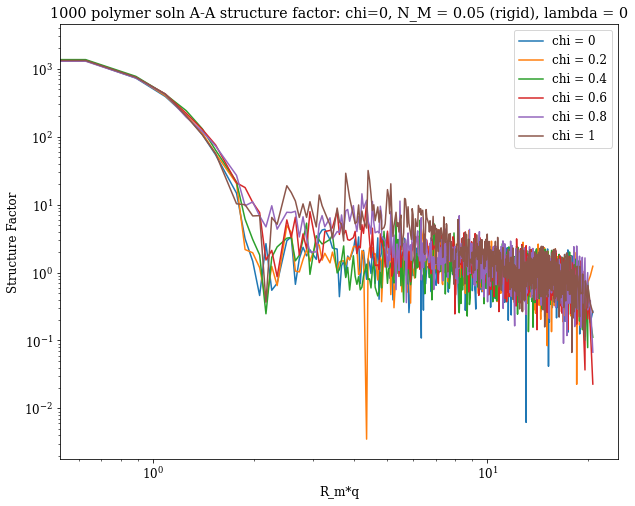

In [255]:
plt.figure(figsize=(10,8))
font = {'family' : 'serif',
    'weight':'normal',
    'size': 12}
plt.rc('font', **font)
sort_magss = np.array(sorted_magnitudes)
for i in range(len(chi_1000_chi_list)):
    plt.loglog(sort_magss*R_M, structure_fact_array_list[i], label = "chi = " + str(chi_1000_chi_list[i])) #*R_M
plt.title("1000 polymer soln A-A structure factor: N_M = 0.05 (rigid), lambda = 0")
plt.xlabel(r'R_m*q')
plt.ylabel(r'Structure Factor')
plt.legend()

### Analytical Solution:

In [5]:
np.version.version

'1.20.3'

In [399]:
# Bead vector itself is the sigma values!
# def sigma(bead_type, comp_type):
#     if bead_type == comp_type:
#         return 1
#     elif bead_type != comp_type:
#         return 0

In [593]:
# #testing if [0,0,1] has same magnitude as [0, 0, -1] .if same mag, shouldnt matter. THEY DO HAVE SAME MAGNITUDE
# A_test = chi_zero_df.Type - 0.5
# B_pos = 1j*np.dot(chi_zero_df.iloc[:,:3], np.array([0, 0, 1]))
# B_neg =  1j*np.dot(chi_zero_df.iloc[:,:3], np.array([0, 0, -1]))

# summ_neg = (A_test*np.exp(B_neg)).sum()
# print(np.absolute(summ_neg))

# summ_pos = (A_test*np.exp(B_pos)).sum()
# print(np.absolute(summ_pos))

In [312]:
# def find_q_vects(q_magnitude):
#     '''
#     already multiplied by L_box and 2pi
#     '''
#     x_arr = np.arange(np.ceil(q_magnitude)+1)
#     y_arr = np.arange(np.ceil(q_magnitude)+1)
#     z_arr = np.arange(np.ceil(q_magnitude)+1)
#     q_init = np.array([])
#     q_failed_init = np.array([])
#     q_init = find_q_vects_rec(q_magnitude, q_init, q_failed_init, x_arr, y_arr, z_arr)
#     return q_init
    
# def find_q_vects_rec(q_magnitude, q_correct, q_failed, x_arr_rem, y_arr_rem, z_arr_rem):
#     #print("before running, q_correct is:", q_correct)
#     if x_arr_rem.size == 0 and y_arr_rem.size == 0 and z_arr_rem.size == 0:
#         #stopping condition
#         return q_correct
#     else:
#         if x_arr_rem.size==0:
#             x = np.ceil(q_magnitude)
#         else:
#             x = x_arr_rem[0]
            
#         if y_arr_rem.size==0:
#             y = np.ceil(q_magnitude)
#         else:
#             y = y_arr_rem[0]
        
#         if z_arr_rem.size==0:
#             z = np.ceil(q_magnitude)
#         else:
#             z = z_arr_rem[0] 
        
#         pos_vect = np.array([x, y, z])
#         #print("-----------------")
#         #print("pos_vect is:", pos_vect)
#         #print("q_correct is:", q_correct)
#         #print("q_failed is:", q_failed)
#         #determine if any permutation of this vector have already been 
#         permutes = list(itertools.permutations(pos_vect))
#         for i in range(len(permutes)):
#             permutes[i] = list(permutes[i])
#         permutes = np.array(permutes)
        
#         for perm in permutes:
#             #print("one permutation is:", perm)
            
#             perm_in_q = False
#             perm_in_qf = False
#             for q in q_correct:
#                 if np.all([q, perm]):
#                     perm_in_q = True
#                     break
#             for q in q_failed:
#                 if np.all([q, perm]):       
                    
#             if perm_in_q:
#             #if perm in q_correct: #already found a permutation works
#                 #print("ALREADY DONE")
#                 #next recursive step NECESSARY BUT WHY
#                 #q_correct = find_q_vects_rec(q_magnitude, q_correct, q_failed, x_arr_rem, y_arr_rem, z_arr_rem[1:])
#                 #q_correct = find_q_vects_rec(q_magnitude, q_correct, q_failed, x_arr_rem, y_arr_rem[1:], z_arr_rem)
#                 #q_correct = find_q_vects_rec(q_magnitude, q_correct, q_failed, x_arr_rem[1:], y_arr_rem, z_arr_rem)

#                 return q_correct
#              elif perm in q_failed:
# #                 print(perm in q_failed)
# #                 #already found a permutation failed
# #                 print("already failed!!!")
# #                 return q_correct
#         #print("mag is:", np.linalg.norm(pos_vect))
#         if np.linalg.norm(pos_vect) == q_magnitude:
#             #print("is good!")
#             if q_correct.size == 0:
#                 q_correct = np.array([pos_vect])
#             else:
#                 q_correct = np.append(q_correct, [pos_vect], axis=0)
            
#             #next recursive step
#             q_correct = find_q_vects_rec(q_magnitude, q_correct, q_failed, x_arr_rem, y_arr_rem, z_arr_rem[1:])
#             q_correct = find_q_vects_rec(q_magnitude, q_correct, q_failed, x_arr_rem, y_arr_rem[1:], z_arr_rem)
#             q_correct = find_q_vects_rec(q_magnitude, q_correct, q_failed, x_arr_rem[1:], y_arr_rem, z_arr_rem)
            
#             return q_correct

#         else:
#             if q_failed.size == 0:
#                 q_failed = np.array([pos_vect])
#             else:
#                 q_failed = np.append(q_failed, [pos_vect], axis=0)
            

#             #next recursive step
#             q_correct = find_q_vects_rec(q_magnitude, q_correct, q_failed, x_arr_rem, y_arr_rem, z_arr_rem[1:])
#             q_correct = find_q_vects_rec(q_magnitude, q_correct, q_failed, x_arr_rem, y_arr_rem[1:], z_arr_rem)
#             q_correct = find_q_vects_rec(q_magnitude, q_correct, q_failed, x_arr_rem[1:], y_arr_rem, z_arr_rem)
            
#             return q_correct
        
#     return q_correct

